In [1]:
import torch
from torch.distributions import Normal, Gamma
import math
import matplotlib.pyplot as plt

## Bayesian Inferencing of Precision of Gaussian likelihood, known Mean

We will study the case where the mean is known but the variance is unknown and expressed as a random variable. The computations become quite a bit simpler if we use precision (inverse of variance).

We will only express the variance as a random variable while the mean will be a constant.

Precision, $\lambda$ which is related to variance $\sigma$ as $\lambda = \frac{ 1 } { \sigma^{2} }$.

The likelihood term becomes
$$
p\left( X \middle\vert \lambda\right) = \frac{ \lambda^{ \frac{ n }{ 2 } } } { { \sqrt {2\pi }  } } e^{ -\frac{ \lambda }{ 2 } \sum_{i=1}^n \left( {x^{ \left( i \right) } - \mu } \right)^2 }$$

The prior for the precision is a Gamma distribution
$$
p\left( \lambda \right)  = \frac{ \beta_{0}^{ \alpha_{0} } }{ \Gamma\left( \alpha_{0} \right) } \lambda ^{ \left( \alpha_{0} - 1 \right)} e^{ - \beta_{0} \lambda  }
$$

The corresponding posterior is also a Gamma distribution, such that 

$$p\left( \lambda \middle\vert X \right) = \frac{ \beta_{n}^{ \alpha_{n} } }{ \Gamma\left( \alpha_{n} \right) } \lambda ^{ \left( \alpha_{n} - 1 \right)} e^{ - \beta_{n} \lambda} $$

where 
$$ \alpha_{n}  = \frac{ n }{ 2 } + \alpha_{0} \\
\beta_{n} = \frac{ 1 }{ 2 } \sum_{i=1}^{n} \left( {x^{ \left( i \right) } - \mu } \right)^2 + \beta_{0} = \frac{ n }{ 2 } s + \beta_{0} $$

In [2]:
def inference_unknown_variance(X, prior_dist):
    sigma_mle = torch.std(X)
    n = X.shape[0]
    
    # Parameters of the prior
    alpha_0 = prior_dist.concentration
    beta_0 = prior_dist.rate
    
    # Parameters of posterior
    alpha_n = n / 2 + alpha_0
    beta_n = n / 2 * sigma_mle ** 2 + beta_0
    posterior_dist = Gamma(alpha_n, beta_n)
    return posterior_dist

In [3]:
def plot_distribution(dists, legend, precisions, precision_legend, title, xlim=(0, 4)):
    fig, ax = plt.subplots(dpi=400)
    ax.set_title(title)
    ax.set_ylabel("PDF(X)")
    ax.set_xlabel("X")
    y_lim = 0
    for dist in dists:
        x = torch.linspace(0.01, 10, 1000)
        pdf = dist.log_prob(x).exp()
        ax.plot(x, pdf)
        y_lim = max(torch.max(pdf), y_lim)
    for precision in precisions:
        ax.plot([precision] * len(x) , x, '--')
    ax.set_xlim(*xlim)
    ax.set_ylim(0, y_lim+0.01)
    legend.extend(precision_legend)
    ax.legend(legend, loc='upper right')
    return ax

In [4]:
# Let us assume that the true distribution is a normal distribution. The true distribution corresponds 
# to a single class.
mu_known = 20
true_dist = Normal(mu_known, 5)

In [5]:
# Case 1
# Let us assume our prior is a Gamma distribution with a good estimate of the variance
prior_dist = Gamma(1, 10)

# Let us set a seed for reproducability
torch.manual_seed(42)

# Number of samples is low. 
n = 3
X = true_dist.sample((n,))
posterior_dist_low_n = inference_unknown_variance(X, prior_dist)

precision_mle = (1 / X.std()**2)

true_precision = (1/ true_dist.scale**2)

max_posterior_precision = (posterior_dist_low_n.concentration-1) / posterior_dist_low_n.rate

# When n is low, the posterior is dominated by the prior. Thus, a good prior can help offset the lack of data.
# We can see this in the following case. 

# With a small sample (n=3), the MLE estimate of precision is 3.70, which is way off from the true value of 0.04
# Using a good prior here helps offset it. The MAP estimate of precision, 0.14 is much better.  

print(f"True precision: {true_precision:0.2f}")
print(f"MAP precision: {max_posterior_precision:0.2f}")
print(f"MLE precision: {precision_mle:0.2f}")

True precision: 0.04
MAP precision: 0.14
MLE precision: 3.70


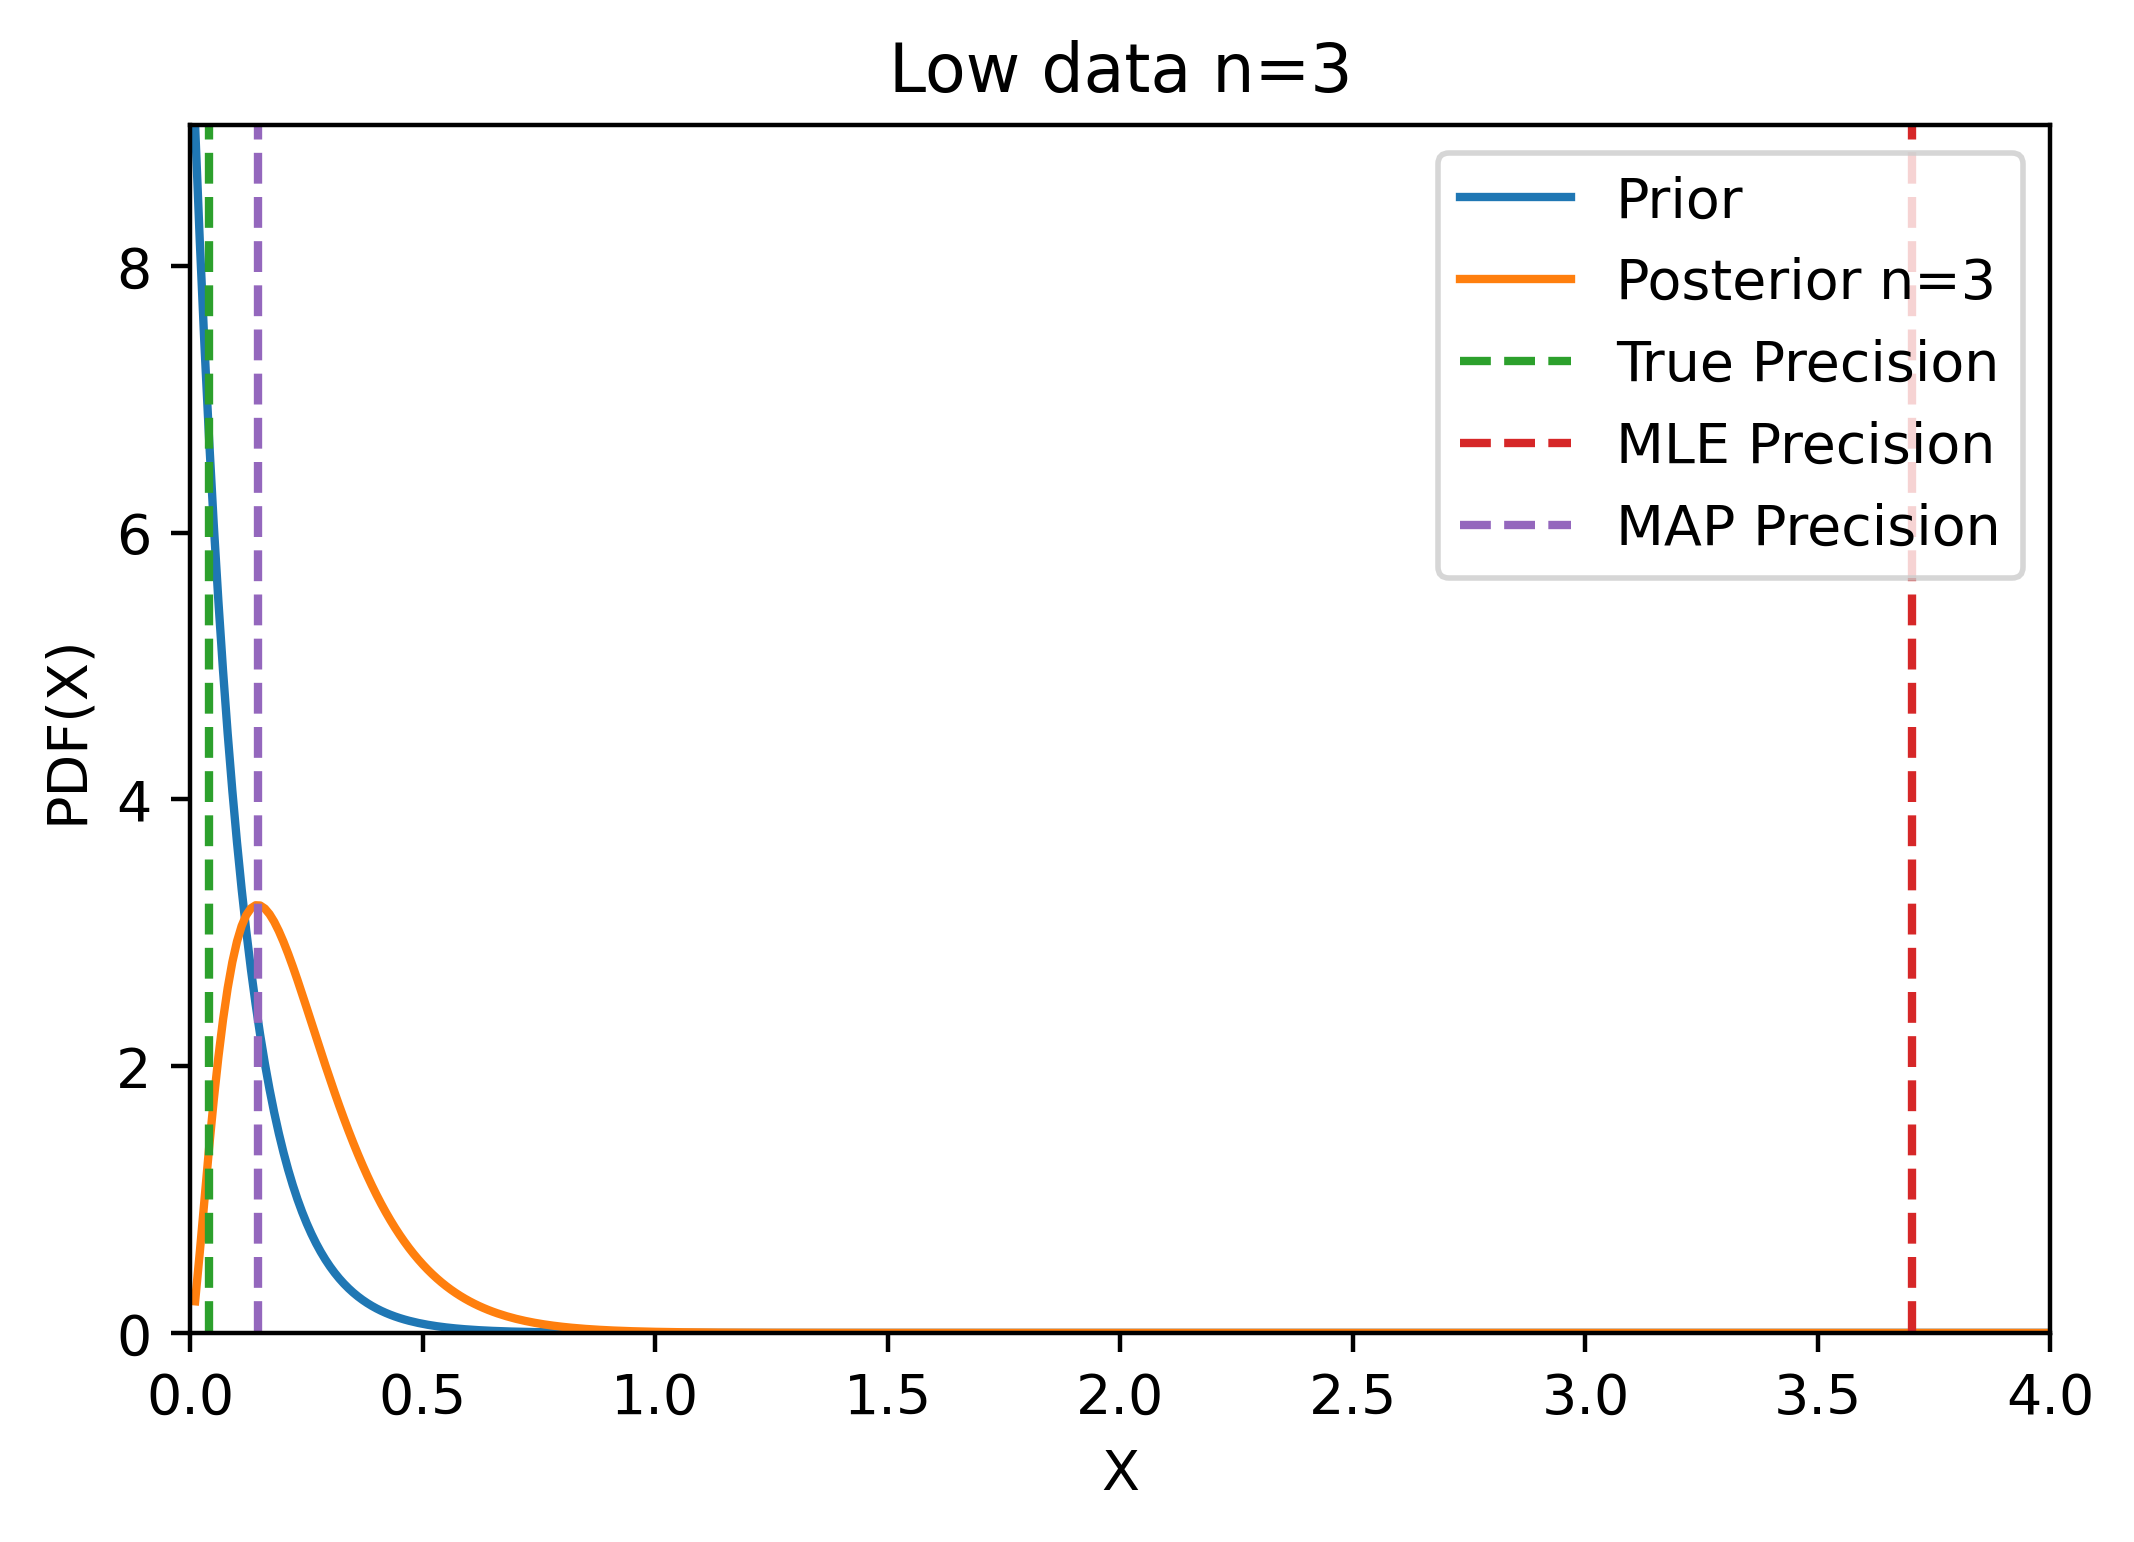

In [6]:
dists = [prior_dist, posterior_dist_low_n]
legend = ["Prior", "Posterior n=3"]

precisions = [true_precision, precision_mle, max_posterior_precision]
legend_p = ["True Precision", "MLE Precision", "MAP Precision"]

plot_distribution(dists, legend, precisions, legend_p, "Low data n=3",)
plt.show()

In [7]:
# Case 2
# Let us assume our prior is a Gamma distribution with a good estimate of the variance
prior_dist = Gamma(1, 10)

# Let us set a seed for reproducability
torch.manual_seed(42)

# Number of samples is high. 
n = 100
X = true_dist.sample((n,))
posterior_dist_high_n = inference_unknown_variance(X, prior_dist)

precision_mle = (1 / X.std()**2)

true_precision = (1/ true_dist.scale**2)

max_posterior_precision = (posterior_dist_high_n.concentration-1) / posterior_dist_high_n.rate


# When n is high, the MLE tends to converge to the true distribution. The MAP also tends to converge to the MLE, 
# and in turn converges to the true distribution
print(f"True precision: {true_precision:0.2f}")
print(f"MAP precision: {max_posterior_precision:0.2f}")
print(f"MLE precision: {precision_mle:0.2f}")

True precision: 0.04
MAP precision: 0.04
MLE precision: 0.04


### How to use the  estimated variance parameter?

As before, we will find the parameter value that maximizes the posterior density. Here we will maximize the posterior probability density function for the precision $p\left( \lambda \middle\vert X \right) = \lambda^{ \left( \alpha_{n} - 1 \right) } e^{ -\beta_{n} \lambda }$ by taking the derivative and equating to zero.

This gives us $$\lambda = \frac{ \alpha - 1 }{ \beta }$$

Thus, our estimated distribution for the class of points corresponding to the training data is $\mathcal{N}\left( x ; \;\; \mu, \sigma_{n} \right)$ where $\frac{1}{ \sigma_{n}^{2} } = \left( \frac{ \alpha_{n} - 1 }{ \beta_{n}  } \right)^{ -\frac{1}{2} }$.

In [8]:
map_precision = (posterior_dist_high_n.concentration-1) / posterior_dist_high_n.rate
map_dist = Normal(mu_known, 1/ math.sqrt(map_precision))
print(f"MAP distribution mu: {map_dist.mean:0.2f} std:{map_dist.scale:0.2f}")

MAP distribution mu: 20.00 std:4.95
